<a href="https://colab.research.google.com/github/timothy2077/1st-Rep/blob/master/Exploration_Project_F_082724.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **12-1. 프로젝트: ControlNet으로 조건을 준 이미지 생성하기**

In [ ]:
# Stable Diffusion 설치
!pip install --upgrade -qq git+https://github.com/huggingface/diffusers.git transformers accelerate

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 55.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 315.1/315.1 kB 15.9 MB/s eta 0:00:00


In [ ]:
# 메모리 삭제
# torch.cuda.empty_cache()

## 1. 윤곽선 검출

In [ ]:
import torch
from diffusers import StableDiffusionControlNetPipeline
from diffusers.utils import load_image

# 이미지 불러오기
image = load_image(
    "https://hf.co/datasets/huggingface/documentation-images/resolve/main/diffusers/input_image_vermeer.png"
)

image

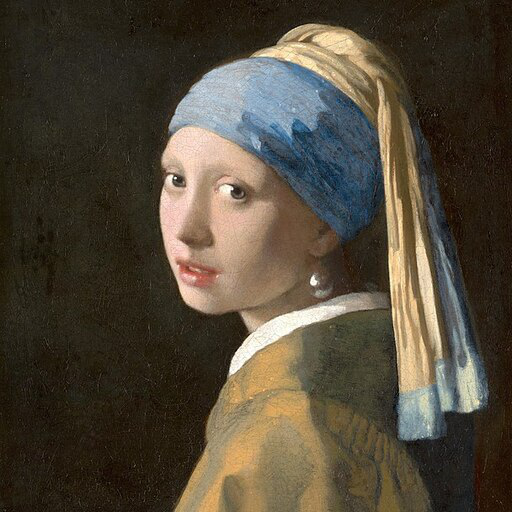

## OpenCV를 사용하여 이미지의 윤곽선을 검출하기

In [ ]:
import cv2
from PIL import Image
import numpy as np

# 이미지를 NumPy 배열로 변환
image = np.array(image)

# threshold를 지정
low_threshold = 100
high_threshold = 200

# 윤곽선을 검출
image = cv2.Canny(image, low_threshold, high_threshold)
image = image[:, :, None]
image = np.concatenate([image, image, image], axis=2)
canny_image = Image.fromarray(image)  # NumPy 배열을 PIL 이미지로 변환

canny_image

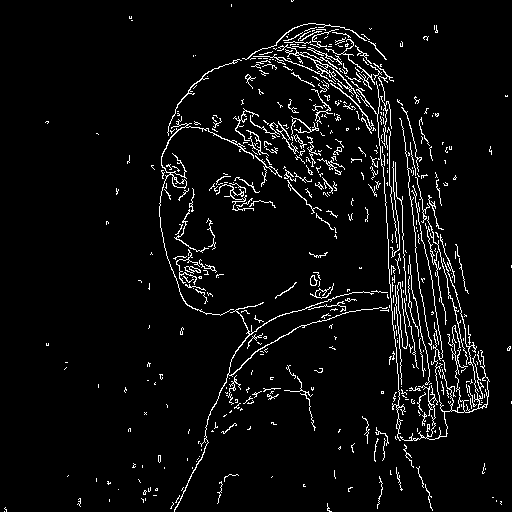

## 윤곽선 검출 전처리기를 사용한 모델 파이프라인을 불러오기

In [ ]:
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel

canny_controlnet = ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-canny", torch_dtype=torch.float16)
canny_pipe = StableDiffusionControlNetPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5", controlnet=canny_controlnet, torch_dtype=torch.float16
)

## 윤곽선을 추출한 이미지에 프롬프트를 적용하여 새로운 이미지를 생성하기

In [ ]:
from diffusers import UniPCMultistepScheduler
canny_pipe.scheduler = UniPCMultistepScheduler.from_config(canny_pipe.scheduler.config)
canny_pipe = canny_pipe.to("cuda")

# 동일한 이미지를 생성하기 위해 seed를 지정
generator = torch.manual_seed(0)

# 이미지를 생성
canny_image = canny_pipe(
    prompt="disco dancer with colorful lights",
    num_inference_steps=20,
    generator=generator,
    image=canny_image
).images[0]

# 생성된 이미지를 저장
canny_image.save("/aiffel/aiffel/canny_image.png")

# 생성된 이미지를 출력
canny_image

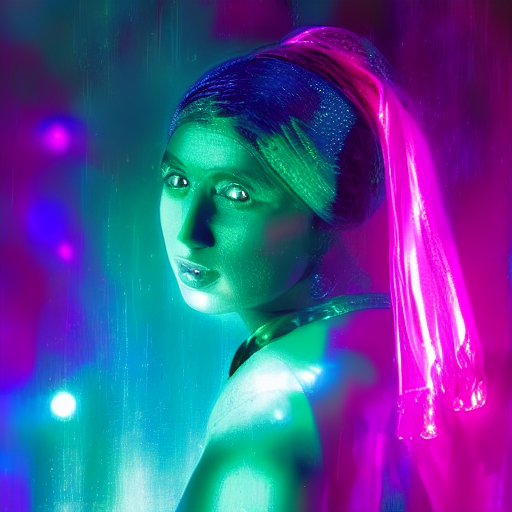

## ChatGPT를 사용하여 부정적인 프롬프트를 작성하고 HP를 조절하여 이미지를 생성해 보기

In [ ]:
# Q. 프롬프트를 작성하고 하이퍼파라미터를 조절하여 이미지를 생성
from diffusers import UniPCMultistepScheduler
import torch

# 파이프라인 설정
canny_pipe.scheduler = UniPCMultistepScheduler.from_config(canny_pipe.scheduler.config)
canny_pipe = canny_pipe.to("cuda")

# 동일한 이미지를 생성하기 위해 seed를 지정
generator = torch.manual_seed(0)

# 프롬프트와 부정적인 프롬프트 설정
prompt = "disco dancer with colorful lights"
negative_prompt = "blurry, low quality"

# 이미지를 생성
canny_image = canny_pipe(
    prompt=prompt,
    negative_prompt=negative_prompt,
    num_inference_steps=20,
    guidance_scale=7.5,
    controlnet_conditioning_scale=1.0,
    generator=generator,
    image=canny_image
).images[0]

# 생성된 이미지를 저장
canny_image.save("/aiffel/aiffel/canny_image.png")

# 생성된 이미지를 출력
canny_image.show()


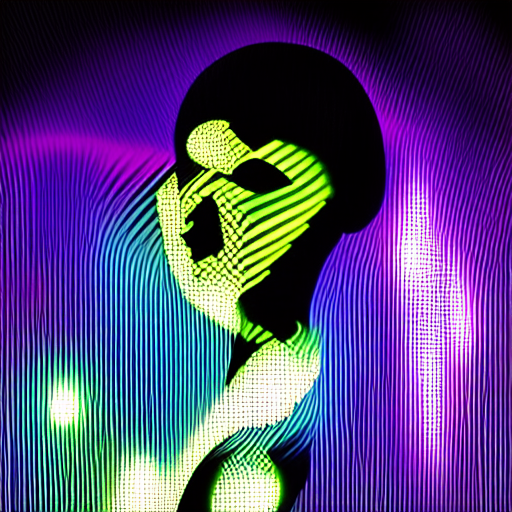

# 2. 인체 자세 감지

In [ ]:
# controlnet-aux를 설치
!pip install controlnet-aux==0.0.1

## 사람의 전신이 담긴 이미지를 불러오기

In [ ]:
from diffusers.utils import load_image

openpose_image = load_image(
    "https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/diffusers/person.png"
)
openpose_image

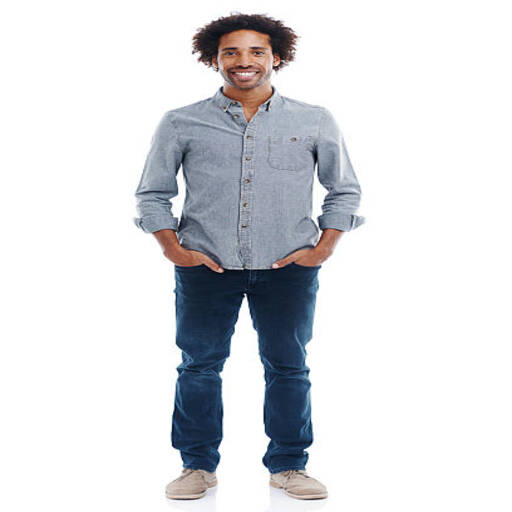

## Openpose 검출기를 사용하면 자세만 추출하기

In [ ]:
from controlnet_aux import OpenposeDetector

# 인체의 자세를 검출하는 사전 학습된 ControlNet 불러오기
openpose = OpenposeDetector.from_pretrained("lllyasviel/ControlNet")

# 이미지에서 자세 검출
openpose_image = openpose(openpose_image)
openpose_image

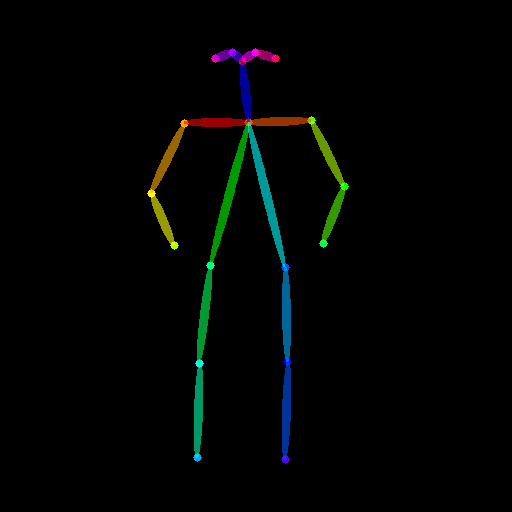

## Openpose 전처리기를 사용한 모델 파이프라인을 불러오기

In [ ]:
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel

openpose_controlnet = ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-openpose", torch_dtype=torch.float16)
openpose_pipe = StableDiffusionControlNetPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5", controlnet=openpose_controlnet, torch_dtype=torch.float16
)

## Canny Edge Detection에서 사용한 코드를 참고 및 HP 조절하여 새롭고 더 멋진 이미지를 생성하기

In [ ]:
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel
import torch
from PIL import Image
import requests
from io import BytesIO

# ControlNet 모델 로드
openpose_controlnet = ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-openpose", torch_dtype=torch.float16)
openpose_pipe = StableDiffusionControlNetPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5", controlnet=openpose_controlnet, torch_dtype=torch.float16
)

# GPU 사용 설정
device = "cuda" if torch.cuda.is_available() else "cpu"
openpose_pipe.to(device)

# 동일한 이미지를 생성하기 위해 seed를 지정
generator = torch.manual_seed(0)

# 프롬프트와 부정적인 프롬프트 설정
prompt = "A stylish young woman riding a bicycle in an urban setting. She is wearing a fashionable outfit, vibrant colors, sunny day"
negative_prompt = "blurry, low quality, dark, out of focus, overexposed"

# 이미지 URL
image_url = "https://plus.unsplash.com/premium_photo-1681483932486-1697dac3af23?q=80&w=1887&auto=format&fit=crop&ixlib=rb-4.0.3&ixid=M3wxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8fA%3D%3D"

# 이미지 다운로드
response = requests.get(image_url)
# 바이트 스트림에서 이미지 열기
openpose_image = Image.open(BytesIO(response.content)).convert("RGB")  # 이미지를 RGB로 변환

# 이미지 크기 줄이기
openpose_image = openpose_image.resize((512, 512))

# 이미지를 생성
generated_images = openpose_pipe(
    prompt=prompt,
    negative_prompt=negative_prompt,
    num_inference_steps=50,  # 추론 횟수 증가
    guidance_scale=8.5,  # 프롬프트에 근접한 이미지 생성
    controlnet_conditioning_scale=1.0,  # ControlNet 조건 설정
    generator=generator,  # Generator 객체 사용
    image=openpose_image,  # 이미지 인자 설정
).images

# 생성된 이미지를 저장합니다.
generated_images[0].save("/aiffel/aiffel/openpose_image.png")

# 생성된 이미지를 출력합니다.
generated_images[0].show()






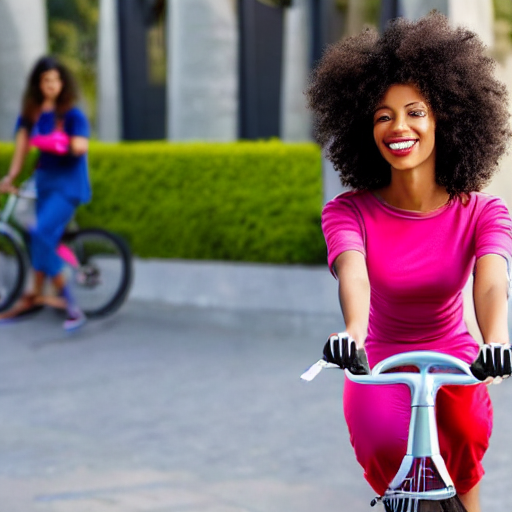

## 이미지 크기를 줄이고 부정적인 프롬프트 설정하여 새로운 이미지 생성하기

In [ ]:
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel, UniPCMultistepScheduler
import torch
from PIL import Image
import requests
from io import BytesIO

# ControlNet 모델 로드
openpose_controlnet = ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-openpose", torch_dtype=torch.float16)
openpose_pipe = StableDiffusionControlNetPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5", controlnet=openpose_controlnet, torch_dtype=torch.float16
)

# 파이프라인 설정
openpose_pipe.scheduler = UniPCMultistepScheduler.from_config(openpose_pipe.scheduler.config)
openpose_pipe = openpose_pipe.to("cuda")

# 동일한 이미지를 생성하기 위해 seed를 지정
generator = torch.manual_seed(0)

# 프롬프트와 부정적인 프롬프트 설정
prompt = "A stylish young woman riding a bicycle in an urban setting. She is wearing a fashionable outfit"
negative_prompt = "dark, blurry, low quality, abstract, surreal, exaggerated, unrealistic, muted colors, chaotic background, low resolution, rough brushstrokes, cartoonish"

# 이미지 URL
image_url = "https://plus.unsplash.com/premium_photo-1681483932486-1697dac3af23?q=80&w=1887&auto=format&fit=crop&ixlib=rb-4.0.3&ixid=M3wxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8fA%3D%3D"

# 이미지 다운로드
response = requests.get(image_url)
# 바이트 스트림에서 이미지 열기
openpose_image = Image.open(BytesIO(response.content)).convert("RGB")  # 이미지를 RGB로 변환

# 이미지 크기 줄이기
openpose_image = openpose_image.resize((512, 512))

# 이미지를 생성합니다.
generated_images = openpose_pipe(
    prompt=prompt,
    negative_prompt=negative_prompt,
    num_inference_steps=20,  # 최소 추론 횟수
    guidance_scale=5.0,  # 최소 가이던스 스케일
    controlnet_conditioning_scale=0.5,  # 최소 ControlNet 조건 설정
    generator=generator,  # Generator 객체 사용
    image=openpose_image,  # 이미지 인자 설정
).images

# 생성된 이미지를 저장
generated_images[0].save("/aiffel/aiffel/openpose_image.png")

# 생성된 이미지를 출력
generated_images[0].show()


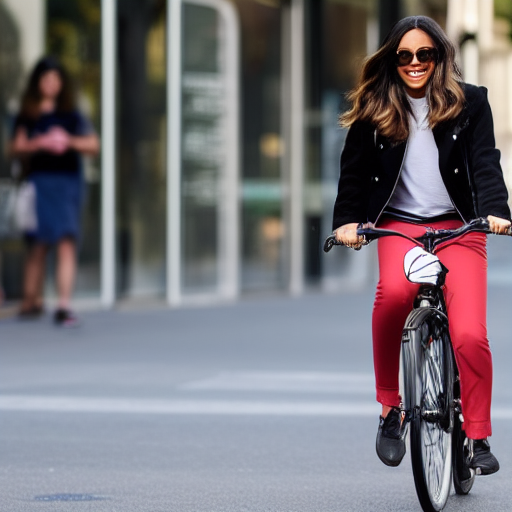

# 3. 윤곽선 검출 + 인체 자세 감지

## Canny 알고리즘을 사용한 윤곽선 검출하기

In [ ]:
from PIL import Image
import cv2
import numpy as np
import requests
from io import BytesIO

# 이미지를 불러오기
image_url = "https://plus.unsplash.com/premium_photo-1681483932486-1697dac3af23?w=500&auto=format&fit=crop&q=60&ixlib=rb-4.0.3&ixid=M3wxMjA3fDB8MHxzZWFyY2h8MXx8ZnJlZSUyMGJpa2luaSUyMG1vZGVsJTIwaW1hZ2UlMjBkb3dubG9hZHxlbnwwfHwwfHx8MA%3D%3D"
response = requests.get(image_url)
image = Image.open(BytesIO(response.content))

# 이미지를 흑백으로 변환
gray_image = np.array(image.convert("L"))

# Canny 알고리즘의 threshold 값을 지정
low_threshold = 100
high_threshold = 200

# Canny 알고리즘을 적용하여 윤곽선을 검출
canny_image = cv2.Canny(gray_image, low_threshold, high_threshold)

# 인체 감지 포즈를 넣어줄 가운데 부분을 지우기
zero_start = canny_image.shape[1] // 4
zero_end = zero_start + canny_image.shape[1] // 2
canny_image[:, zero_start:zero_end] = 0  # 중앙 부분의 윤곽선을 제거하기

# 윤곽선을 검출한 이미지를 NumPy 배열에서 PIL 이미지로 변환
canny_image = Image.fromarray(canny_image)

# 흑백 이미지를 RGB로 변환
canny_image = canny_image.convert("RGB")

# 결과 이미지를 확인하거나 저장
canny_image.show()
canny_image.save("/aiffel/aiffel/canny_image_processed.png")




## 원본 이미지

bikini.avif

## Canny 알고리즘으로 윤곽선을 검출하기

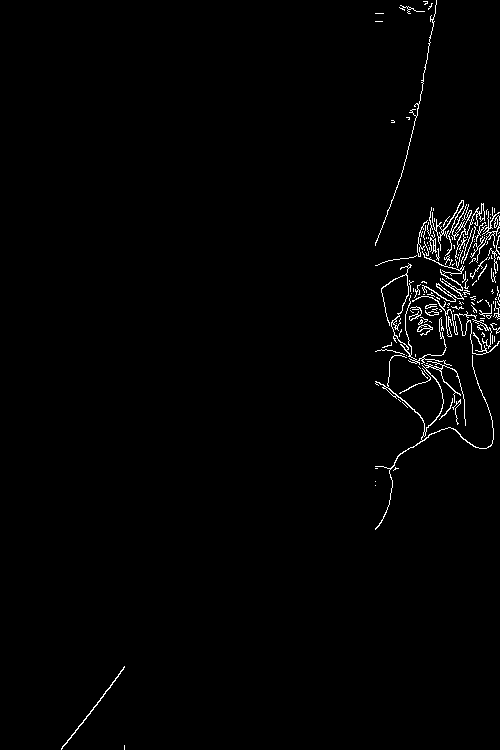

## Openpose를 사용한 인체 자세 검출허기

In [ ]:
from controlnet_aux import OpenposeDetector
from diffusers.utils import load_image
from PIL import Image

# 이미지를 불러옵니다. (로컬 경로 또는 URL)
image_path = "https://plus.unsplash.com/premium_photo-1681483932486-1697dac3af23?w=500&auto=format&fit=crop&q=60&ixlib=rb-4.0.3&ixid=M3wxMjA3fDB8MHxzZWFyY2h8MXx8ZnJlZSUyMGJpa2luaSUyMG1vZGVsJTIwaW1hZ2UlMjBkb3dubG9hZHxlbnwwfHwwfHx8MA%3D%3D"  # 여기에 실제 이미지 경로를 입력하세요
openpose_image = load_image(image_path)  # 이미지 로드

# OpenposeDetector를 사용하여 인체 자세를 검출
openpose = OpenposeDetector.from_pretrained('lllyasviel/ControlNet')  # Pretrained 모델 로드
openpose_image = openpose(openpose_image)  # 인체 자세 검출

# 결과 이미지를 확인하기
openpose_image.show()  # 이미지를 화면에 표시


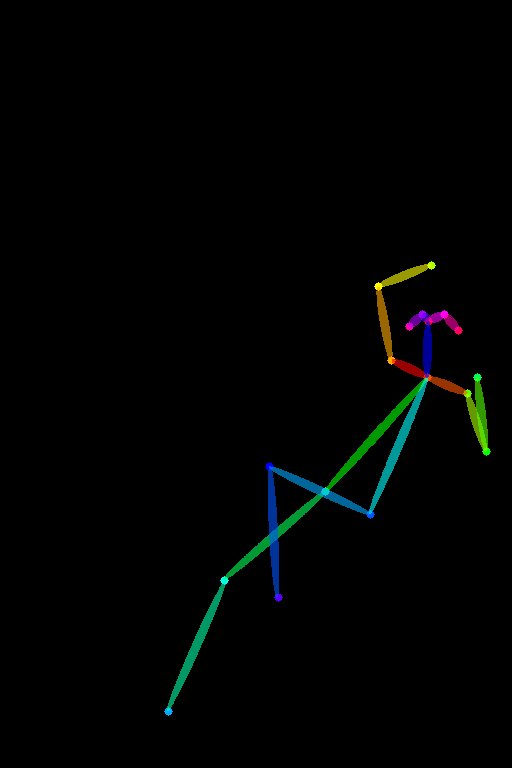

## Edge Detection과 Openpose, 2개의 전처리기를 controlnets라는 리스트로 만들어 파이프라인으로 전달하여 새로운 이미지 만들기

In [ ]:
import torch
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel, UniPCMultistepScheduler
from PIL import Image
import requests
from io import BytesIO

# ControlNet 모델 로드 (Canny와 Openpose)
canny_controlnet = ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-canny")
openpose_controlnet = ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-openpose")

# ControlNet 모델을 리스트로 생성
controlnets = [canny_controlnet, openpose_controlnet]

# 파이프라인 로드
pipe = StableDiffusionControlNetPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5", controlnet=controlnets
)

# 스케줄러 설정
pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)

# GPU를 사용할 수 있는지 확인하고, 사용할 수 없으면 CPU로 설정
if torch.cuda.is_available():
    pipe = pipe.to("cuda")
else:
    pipe = pipe.to("cpu")

# 프롬프트와 부정적인 프롬프트 설정
prompt = "A young woman in a bikini on the beach, clear sky and blue sea, sunlit sandy beach, summer vibes"
negative_prompt = "blurry, low quality, dark, crowded background, low resolution"

# 이미지 다운로드 및 변환 (Canny 이미지 및 Openpose 이미지)
image_url = "https://cdn.jsdelivr.net/gh/boringcdn/sd/sd-generate-2.webp"
response = requests.get(image_url)
canny_image = Image.open(BytesIO(response.content)).convert("RGB")

# 동일한 크기로 조정 (필요할 경우)
width, height = canny_image.size
openpose_image = canny_image.resize((width, height))

# 이미지 리스트 생성
images = [canny_image, openpose_image]

# 이미지 생성
generator = torch.manual_seed(0)
image = pipe(
    prompt=prompt,
    negative_prompt=negative_prompt,
    num_inference_steps=20,
    generator=generator,
    image=images
).images[0]

# 결과 저장 및 출력
image.save("multi_controlnet_output.png")
image.show()


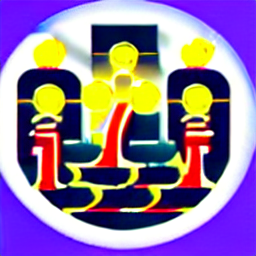


### A.사용한 프롬프트: “미래 도시 풍경과 날아다니는 자동차"
### B.입력한 부정적인 프롬프트: “흐릿한, 저품질, 어두운”

# 4. 프로젝트를 통해 생성된 이미지를 깃헙에 올리기

In [ ]:
print("생성한 이미지를 올린 곳은 [[https://github.com/timothy2077/1st-Rep/blob/master/Exploration_Project__F_082724.ipynb]입니다.")

생성한 이미지를 올린 곳은 [[https://github.com/timothy2077/1st-Rep/blob/master/Exploration_Project__F_082724.ipynb]입니다.


### https://github.com/timothy2077/1st-Rep/blob/master/Exploration_Project_F_082724.ipynb

# **12-2. 24년 8월 27일 최종 프로젝트: Edge Detection과 Openpose,2개의 전처리기를 controlnets라는 리스트로 만들어 파이프라인으로 전달한 후 새로운 이미지를 생성하기**

In [ ]:
!pip install git+https://github.com/huggingface/diffusers
!pip install controlnet_aux opencv-python


  Cloning https://github.com/huggingface/diffusers to /tmp/pip-req-build-5et9on6t
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/diffusers /tmp/pip-req-build-5et9on6t
  Resolved https://github.com/huggingface/diffusers to commit 4cfb2164fb05d54dd594373b4bd1fbb101fef70c
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 282.4/282.4 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.0/510.0 kB 27.9 MB/s eta 0:00:00


## Hugging Face에서 controlnet.safetensors 파일을 다운로드하기

In [ ]:
!wget https://huggingface.co/XLabs-AI/flux-controlnet-canny/resolve/main/controlnet.safetensors

--2024-08-27 04:10:32--  https://huggingface.co/XLabs-AI/flux-controlnet-canny/resolve/main/controlnet.safetensors
Resolving huggingface.co (huggingface.co)... 3.163.189.74, 3.163.189.90, 3.163.189.37, ...
Connecting to huggingface.co (huggingface.co)|3.163.189.74|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs-us-1.huggingface.co/repos/8b/f4/8bf441b05df5b815425be1c70c29388306001bd7944363e84592985d425a92e4/191b98518c3f83554c58da9f5346cdbe64d556801f95a8dbde82c431c5649aa2?response-content-disposition=inline%3B+filename*%3DUTF-8%27%27controlnet.safetensors%3B+filename%3D%22controlnet.safetensors%22%3B&Expires=1724991032&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTcyNDk5MTAzMn19LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy11cy0xLmh1Z2dpbmdmYWNlLmNvL3JlcG9zLzhiL2Y0LzhiZjQ0MWIwNWRmNWI4MTU0MjViZTFjNzBjMjkzODgzMDYwMDFiZDc5NDQzNjNlODQ1OTI5ODVkNDI1YTkyZTQvMTkxYjk4NTE4YzNmODM1NTRjNThkYTlmNTM0NmNkYmU2NGQ1NTY4MDFmO

## Hugging Face의 Stable Diffusion 및 Transformers 라이브러리 설치하기

In [ ]:
# Stable Diffusion 설치
!pip install --upgrade -qq git+https://github.com/huggingface/diffusers.git transformers accelerate

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


## Cntrolnet-aux 패키지(ControlNet 보조 모델) 설치를 통해 인체 자세 검출 기능을 사용하기

In [ ]:
# controlnet-aux를 설치합니다. Human pose를 검출해주는 controlnet의 보조용 모델입니다.
!pip install controlnet-aux==0.0.1

  Attempting uninstall: controlnet-aux
    Found existing installation: controlnet-aux 0.0.9
    Uninstalling controlnet-aux-0.0.9:
      Successfully uninstalled controlnet-aux-0.0.9


In [ ]:
import torch

# 메모리 삭제
torch.cuda.empty_cache()

## Stable Diffusion과 ControlNet을 사용하여 이미지를 생성하기 위한 파이프라인을 설정

In [ ]:
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel

canny_controlnet = ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-canny", torch_dtype=torch.float16)
canny_pipe = StableDiffusionControlNetPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5", controlnet=canny_controlnet, torch_dtype=torch.float16
)

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/920 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/1.45G [00:00<?, ?B/s]

model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

(…)ature_extractor/preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

safety_checker/config.json:   0%|          | 0.00/4.72k [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/308 [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [ ]:
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel

openpose_controlnet = ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-openpose", torch_dtype=torch.float16)
openpose_pipe = StableDiffusionControlNetPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5", controlnet=openpose_controlnet, torch_dtype=torch.float16
)

config.json:   0%|          | 0.00/920 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/1.45G [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

## 1. 윤곽선 검출하기

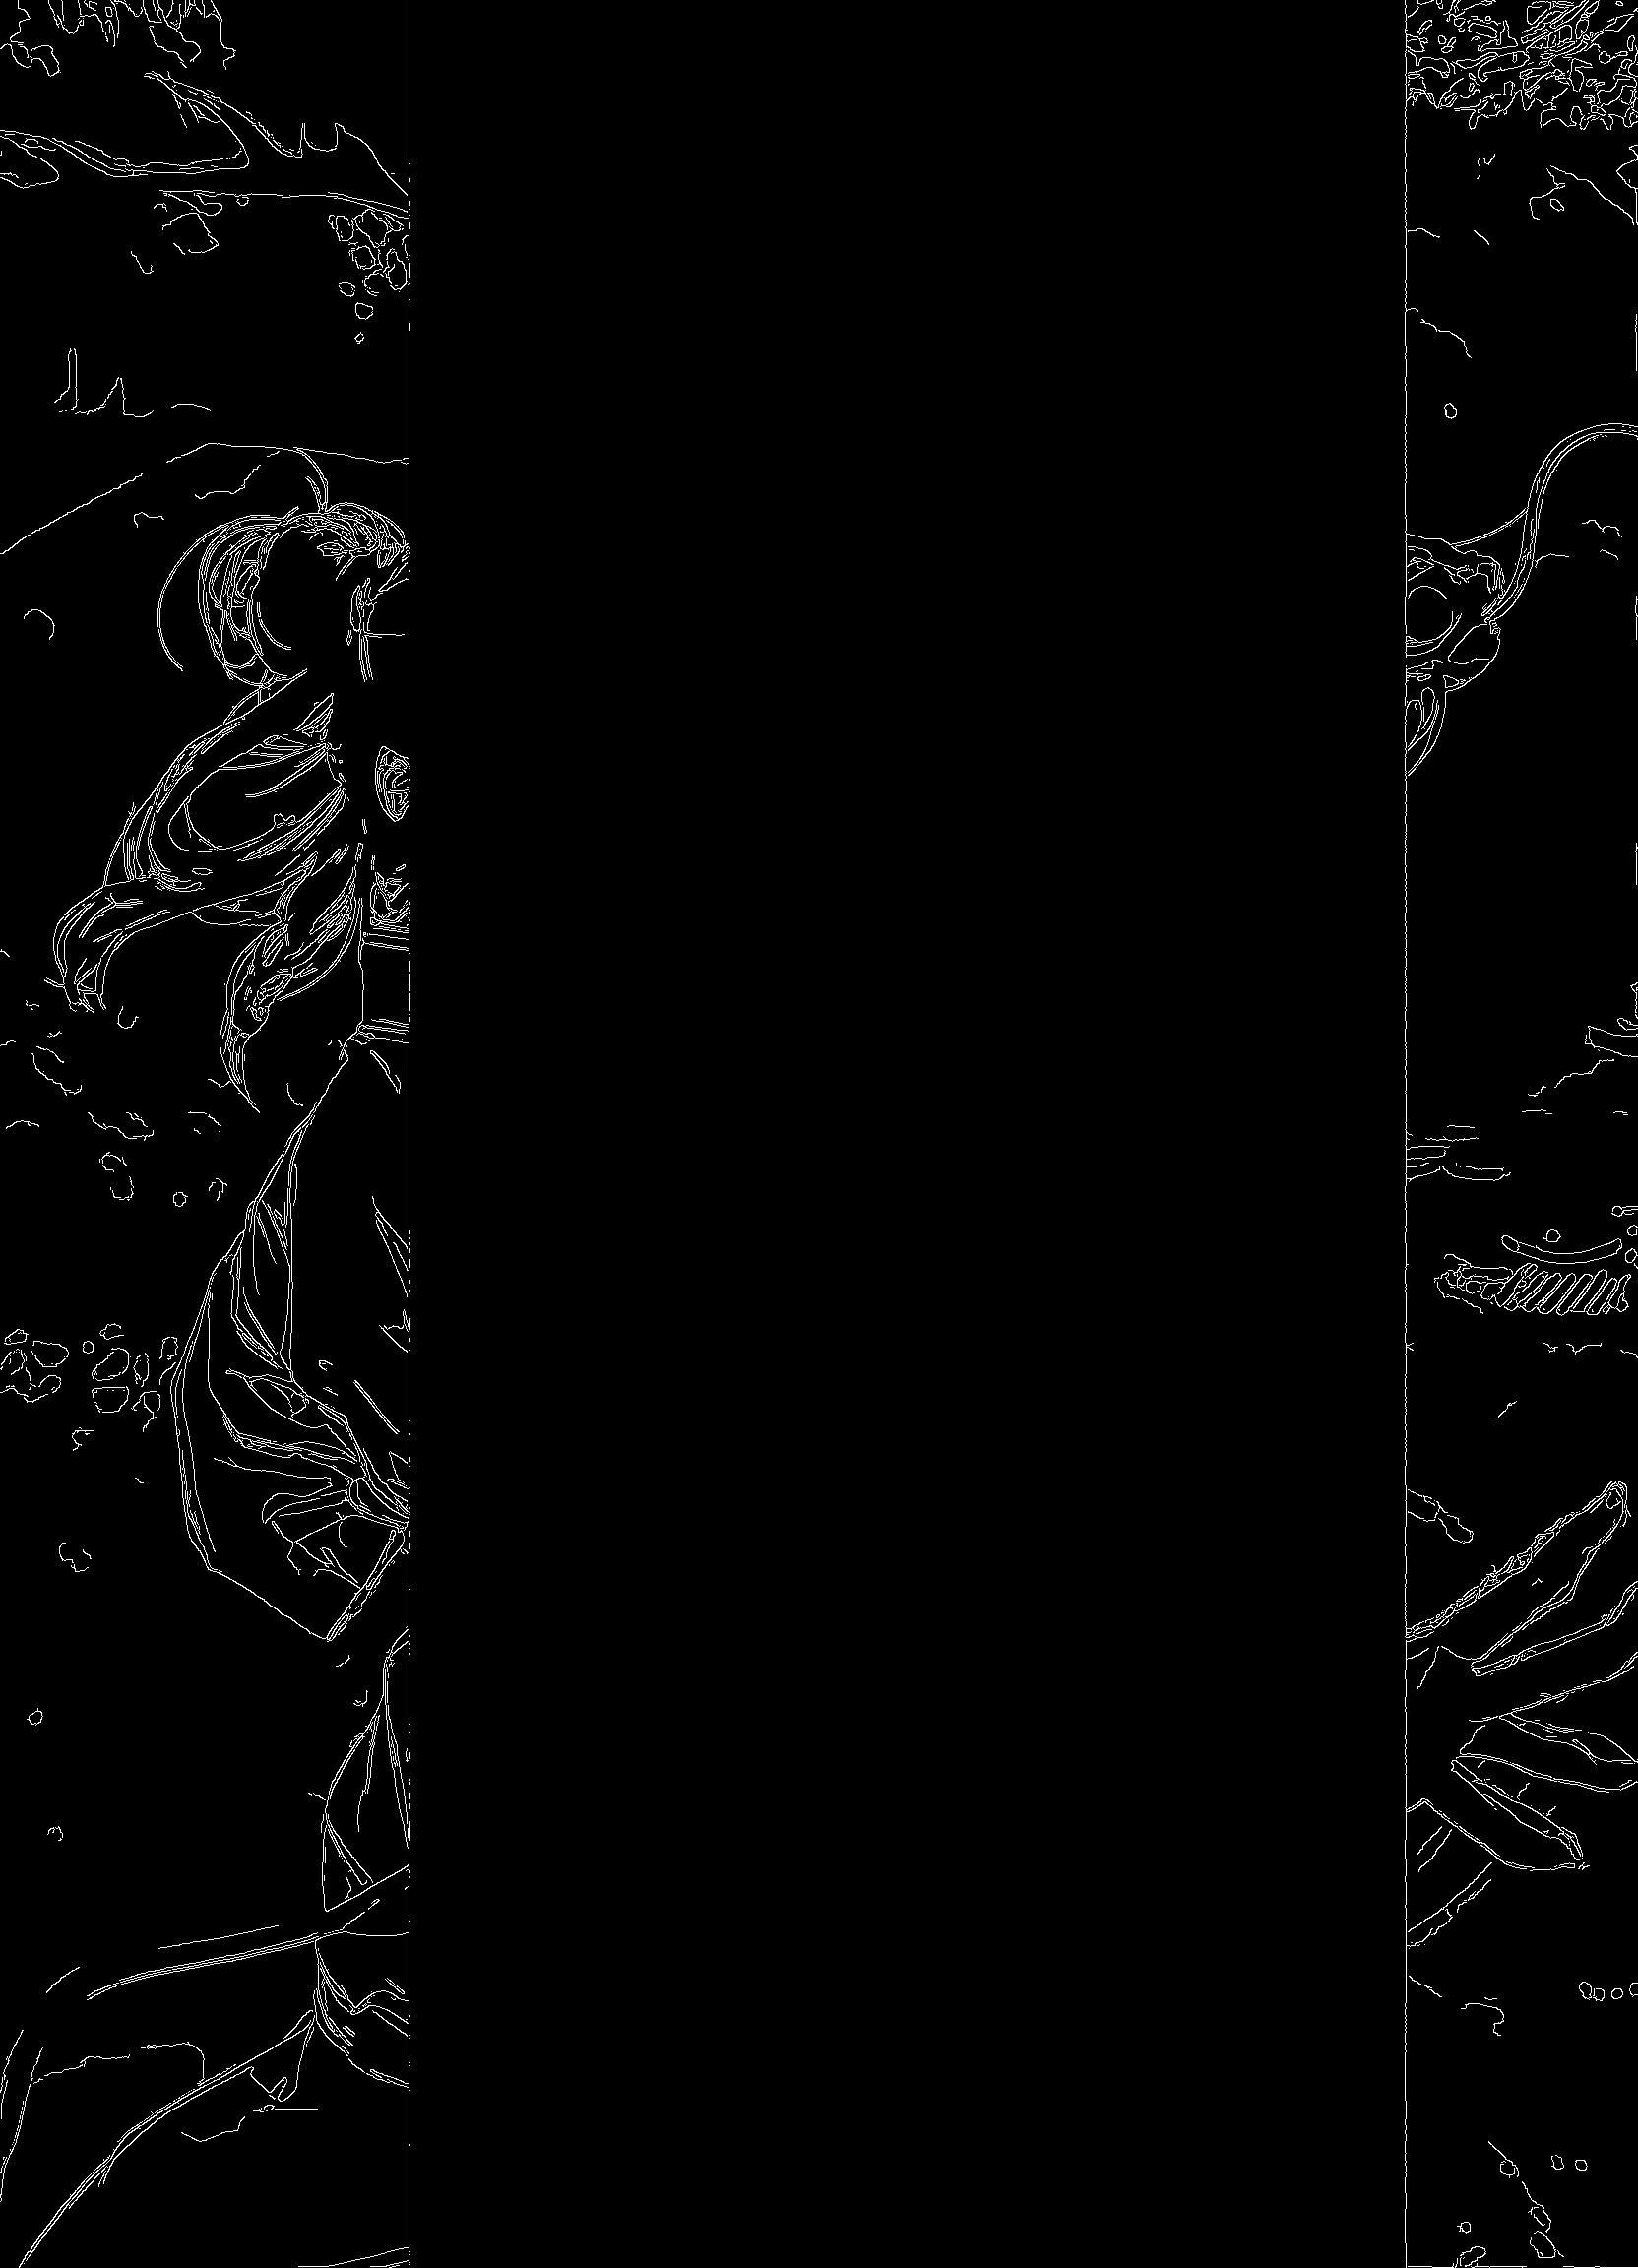

In [ ]:
import torch
from diffusers.utils import load_image
import cv2
from PIL import Image
import numpy as np

image_url = "https://cdn.jsdelivr.net/gh/boringcdn/sd/sd-generate-2.webp"
canny_image = load_image(image_url)


low_threshold = 100
high_threshold = 200


canny_image = np.array(canny_image)

zero_start = canny_image.shape[1] // 4
zero_end = zero_start + canny_image.shape[1] // 2
zero_end += 180
canny_image[:, zero_start:zero_end] = 0

canny_image = cv2.Canny(canny_image, low_threshold, high_threshold)
canny_image = canny_image[:, :, None]
canny_image = np.concatenate([canny_image, canny_image, canny_image], axis=2)
canny_image = Image.fromarray(canny_image)

canny_image


## 2. 인체 자세 감지하기


body_pose_model.pth:   0%|          | 0.00/209M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/controlnet_aux/open_pose/body.py:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_dict = util.transfer(self.model, torch.load(

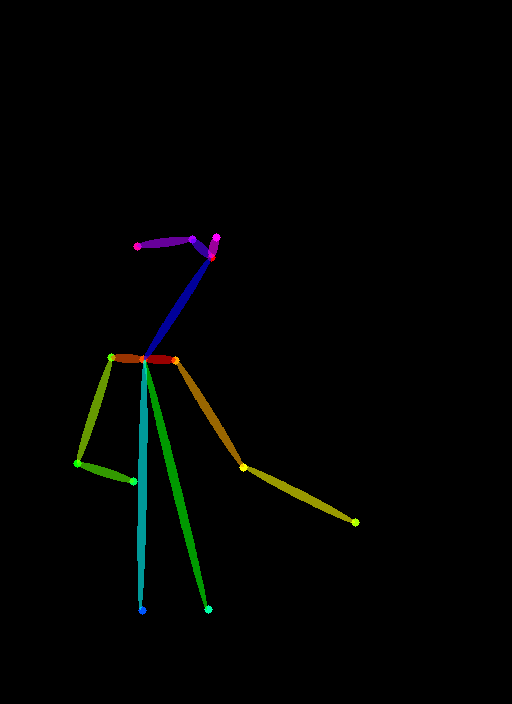

In [ ]:
from controlnet_aux import OpenposeDetector

openpose_image = load_image(
    "https://cdn.jsdelivr.net/gh/boringcdn/sd/sd-generate-2.webp"
)

openpose = OpenposeDetector.from_pretrained("lllyasviel/ControlNet")
openpose_image = openpose(openpose_image)

openpose_image

## 3. 윤곽선 검출하고 인체 자세 감지하기를 실행하여 새로운 이미지 생성하기

In [ ]:
!pip install diffusers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 33.4 MB/s eta 0:00:00


### Setting:
#### 1. GPU/CPU 설정: 코드에서 torch.cuda.is_available()로 GPU를 사용할 수 있는지 확인하고, 사용할 수 없다면 pipe.to("cpu")를 호출해 CPU 모드로 전환하기
### 2. ControlNet 모델: Canny와 Openpose 두 가지 ControlNet 모델을 로드하여 사용하기
### 3. 이미지 처리: 윤곽선 검출 이미지(Canny)와 Openpose 이미지를 동일한 크기로 조정하기
### 4. 이미지 생성: 프롬프트와 함께 ControlNet 모델을 사용해 이미지를 생성하기
### 5. 결과 저장: 생성된 이미지를 파일로 저장하고 화면에 출력하기

In [ ]:
import torch
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel, UniPCMultistepScheduler
from PIL import Image
import requests
from io import BytesIO

# ControlNet 모델 로드 (Canny와 Openpose)
canny_controlnet = ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-canny")
openpose_controlnet = ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-openpose")

# ControlNet 모델을 리스트로 생성
controlnets = [canny_controlnet, openpose_controlnet]

# 파이프라인 로드
pipe = StableDiffusionControlNetPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5", controlnet=controlnets
)

# 스케줄러 설정
pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)

# GPU를 사용할 수 있는지 확인하고, 사용할 수 없으면 CPU로 설정
if torch.cuda.is_available():
    pipe = pipe.to("cuda")
else:
    pipe = pipe.to("cpu")

# 프롬프트 설정
prompt = "Full body, anime art, Young boy practicing martial arts with steel gloves, Chinese dragon in the background, sky garden sanctuary, 4k"
negative_prompt = "blurry, low quality, dark, out of focus, overexposed"

# 이미지 다운로드 및 변환 (Canny 이미지 및 Openpose 이미지)
image_url = "https://cdn.jsdelivr.net/gh/boringcdn/sd/sd-generate-2.webp"
response = requests.get(image_url)
canny_image = Image.open(BytesIO(response.content)).convert("RGB")

# 동일한 크기로 조정 (필요할 경우)
width, height = canny_image.size
openpose_image = canny_image.resize((width, height))

# 이미지 리스트 생성
images = [canny_image, openpose_image]

# 이미지 생성
generator = torch.manual_seed(0)
image = pipe(
    prompt=prompt,
    negative_prompt=negative_prompt,
    num_inference_steps=20,
    generator=generator,
    image=images
).images[0]

# 결과 저장 및 출력
image.save("multi_controlnet_output.png")
image.show()


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

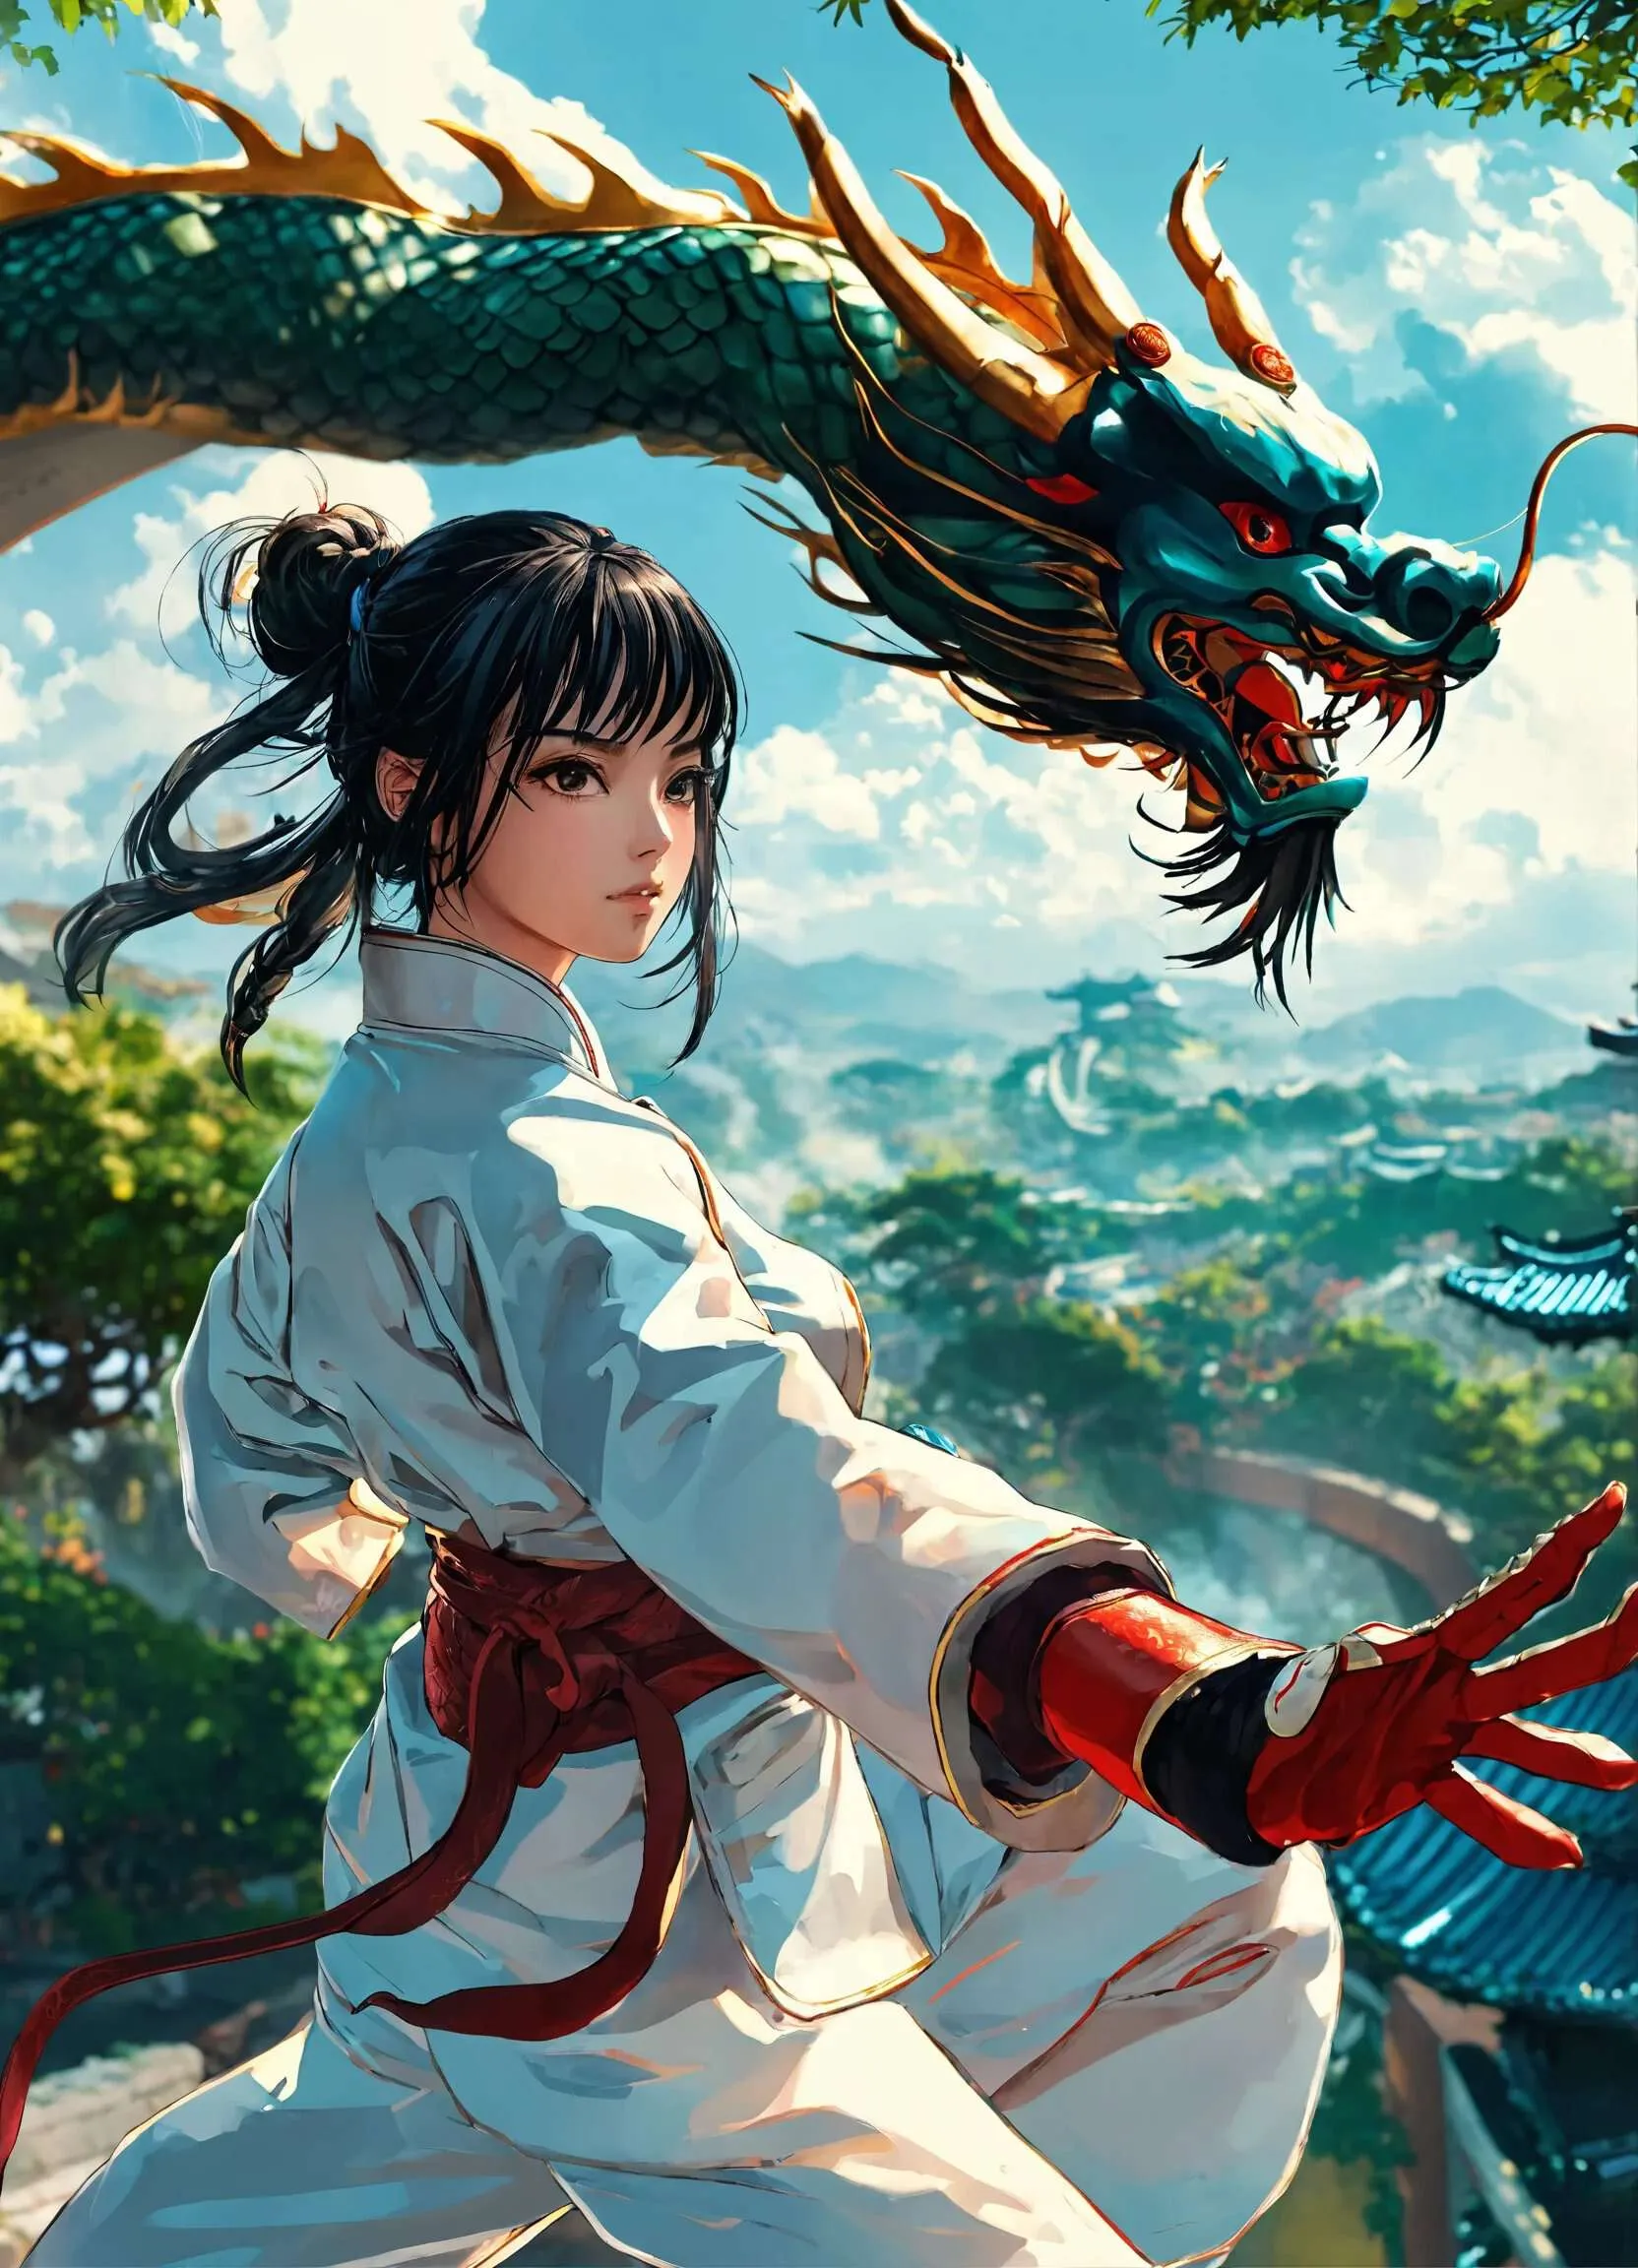